In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from order_of_magnitude import order_of_magnitude
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import combinations

from scipy.stats import mannwhitneyu, wilcoxon, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scikit_posthocs import posthoc_nemenyi_friedman, posthoc_nemenyi
from scipy.stats import chi2, chi2_contingency, chisquare
from scipy.stats import shapiro
from pingouin import multivariate_normality

from fitter import Fitter, get_common_distributions, get_distributions
from distfit import distfit
from scipy.stats import kstest, ks_2samp
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('Exercise.xlsx')
df.columns = list(df.iloc[0, :].values)
df.drop(index=0, inplace=True)
df.drop('Name', axis=1, inplace=True)
df.head()

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE),Suggestion
1,Male,18,152,50,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),2067.152431,Loose Weight,80,21.641274,1392.866,Boy,17.878324,Normal,1671.4392,2131.08498,-0.03,LOW CARB DIET (25:35:40)
2,Male,18,152,54,1. Sedentary or light activity (e.g. - Office ...,2. Lightly active (light exercise/sports 1-3 d...,1705.730935,Maintain Weight,78,23.372576,1447.866,Boy,20.49259,Normal,1990.81575,2215.23498,-0.23,BALANCE DIET (55:25:20)
3,Male,18,152,58,1. Sedentary or light activity (e.g. - Office ...,3. Moderately active (moderate exercise/sports...,1910.142686,Gain Muscle,65,25.103878,1502.866,Boy,23.106856,Overweight,2329.4423,2299.38498,-0.18,BALANCE DIET (55:25:20)
4,Male,18,152,62,3. Vigorously active (Agricultural worker (non...,4. Very active (hard exercise/sports 6-7 days ...,2552.952908,Loose Weight,82,26.83518,1557.866,Boy,25.721122,Overweight,2687.31885,3505.1985,-0.271667,KETOGENIC DIET (5:35:60)
5,Male,18,152,66,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),1826.086885,Maintain Weight,75,28.566482,1612.866,Boy,28.335388,Overweight,1935.4392,2467.68498,-0.26,BALANCE DIET (55:25:20)


In [5]:
df.shape

(10080, 18)

In [6]:
type(df.iloc[0,0]), type(df.iloc[0,1])

(str, int)

In [7]:
print( "Order of magnitude:", order_of_magnitude.order_of_magnitude( [df['Daily Calories Intake'].max(), df['Body Mass Index (BMI)'].max()] ) )

Order of magnitude: [3, 1]


### Convert categorical to numerical

In [8]:
# Mapping String to numeric values.
df['Gender']=df['Gender'].map({"Male":0,"Female":1})
df['Body Type']=df['Body Type'].map({"Underweight":0,"Normal":1,"Overweight":2,"Obese":3})
df['Type']=df['Type'].map({"Boy":0,"Girl":1,"Adult Male":2,"Adult Female":3})
df['Suggestion']=df['Suggestion'].map({"LOW CARB DIET (25:35:40)":0,"BALANCE DIET (55:25:20)":1,"ZONE DIET (40:30:30)":2,"KETOGENIC DIET (5:35:60)":3,"DEPLETION DIET (DYNAMIC)":4,"HIGH CARB DIET(60:20:20)":5})
df['Target']=df['Target'].map({"Loose Weight":0,"Maintain Weight":1,"Gain Muscle":2})
df['Lifestyle']=df['Lifestyle'].map({"1. Sedentary or light activity (e.g. - Office worker getting little or no exercise)":0,"2. Active or moderately active (Construction worker or person running one hour daily)":1,"3. Vigorously active (Agricultural worker (non mechanized) or person swimming two hours daily)":2})
df['Exercise']=df['Exercise'].map({"1. Sedentary (little or no exercise)":0,"2. Lightly active (light exercise/sports 1-3 days/ week)":1,"3. Moderately active (moderate exercise/sports 3-5days/week)":2,"4. Very active (hard exercise/sports 6-7 days a week)":3})

In [9]:
df

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE),Suggestion
1,0,18,152,50,0,0,2067.152431,0,80,21.641274,1392.866,0,17.878324,1,1671.4392,2131.08498,-0.03,0
2,0,18,152,54,0,1,1705.730935,1,78,23.372576,1447.866,0,20.49259,1,1990.81575,2215.23498,-0.23,1
3,0,18,152,58,0,2,1910.142686,2,65,25.103878,1502.866,0,23.106856,2,2329.4423,2299.38498,-0.18,1
4,0,18,152,62,2,3,2552.952908,0,82,26.83518,1557.866,0,25.721122,2,2687.31885,3505.1985,-0.271667,3
5,0,18,152,66,0,0,1826.086885,1,75,28.566482,1612.866,0,28.335388,2,1935.4392,2467.68498,-0.26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10076,1,65,182,76,2,3,3882.93426,1,89,22.944089,1414.548,3,37.082907,1,2440.0953,3182.733,0.22,1
10077,1,65,182,80,2,0,3791.808,2,91,24.151673,1452.8,3,38.532007,1,1743.36,3268.8,0.16,5
10078,1,65,182,84,2,1,2616.79626,0,70,25.359256,1491.052,3,39.981107,2,2050.1965,3354.867,-0.22,0
10079,1,65,182,88,2,2,3131.24994,1,87,26.56684,1529.304,3,41.430208,2,2370.4212,3440.934,-0.09,2


In [10]:
df = df.apply(pd.to_numeric)

In [11]:
type(df.iloc[0,0]), type(df.iloc[0,1])

(numpy.int64, numpy.int64)

### Check for Null value in dataset

In [12]:
df.isnull().sum()

Gender                                                                              0
Age                                                                                 0
Height(cm)                                                                          0
Weight(kg)                                                                          0
Lifestyle                                                                           0
Exercise                                                                            0
Daily Calories Intake                                                               0
Target                                                                              0
How motivated are you for being healthy\n(in %)                                     0
Body Mass Index (BMI)                                                               0
Basal Metabolic Rate (BMR)                                                          0
Type                                                  

In [13]:
df.isna().sum()

Gender                                                                              0
Age                                                                                 0
Height(cm)                                                                          0
Weight(kg)                                                                          0
Lifestyle                                                                           0
Exercise                                                                            0
Daily Calories Intake                                                               0
Target                                                                              0
How motivated are you for being healthy\n(in %)                                     0
Body Mass Index (BMI)                                                               0
Basal Metabolic Rate (BMR)                                                          0
Type                                                  

### Checking Correlation 

<AxesSubplot:>

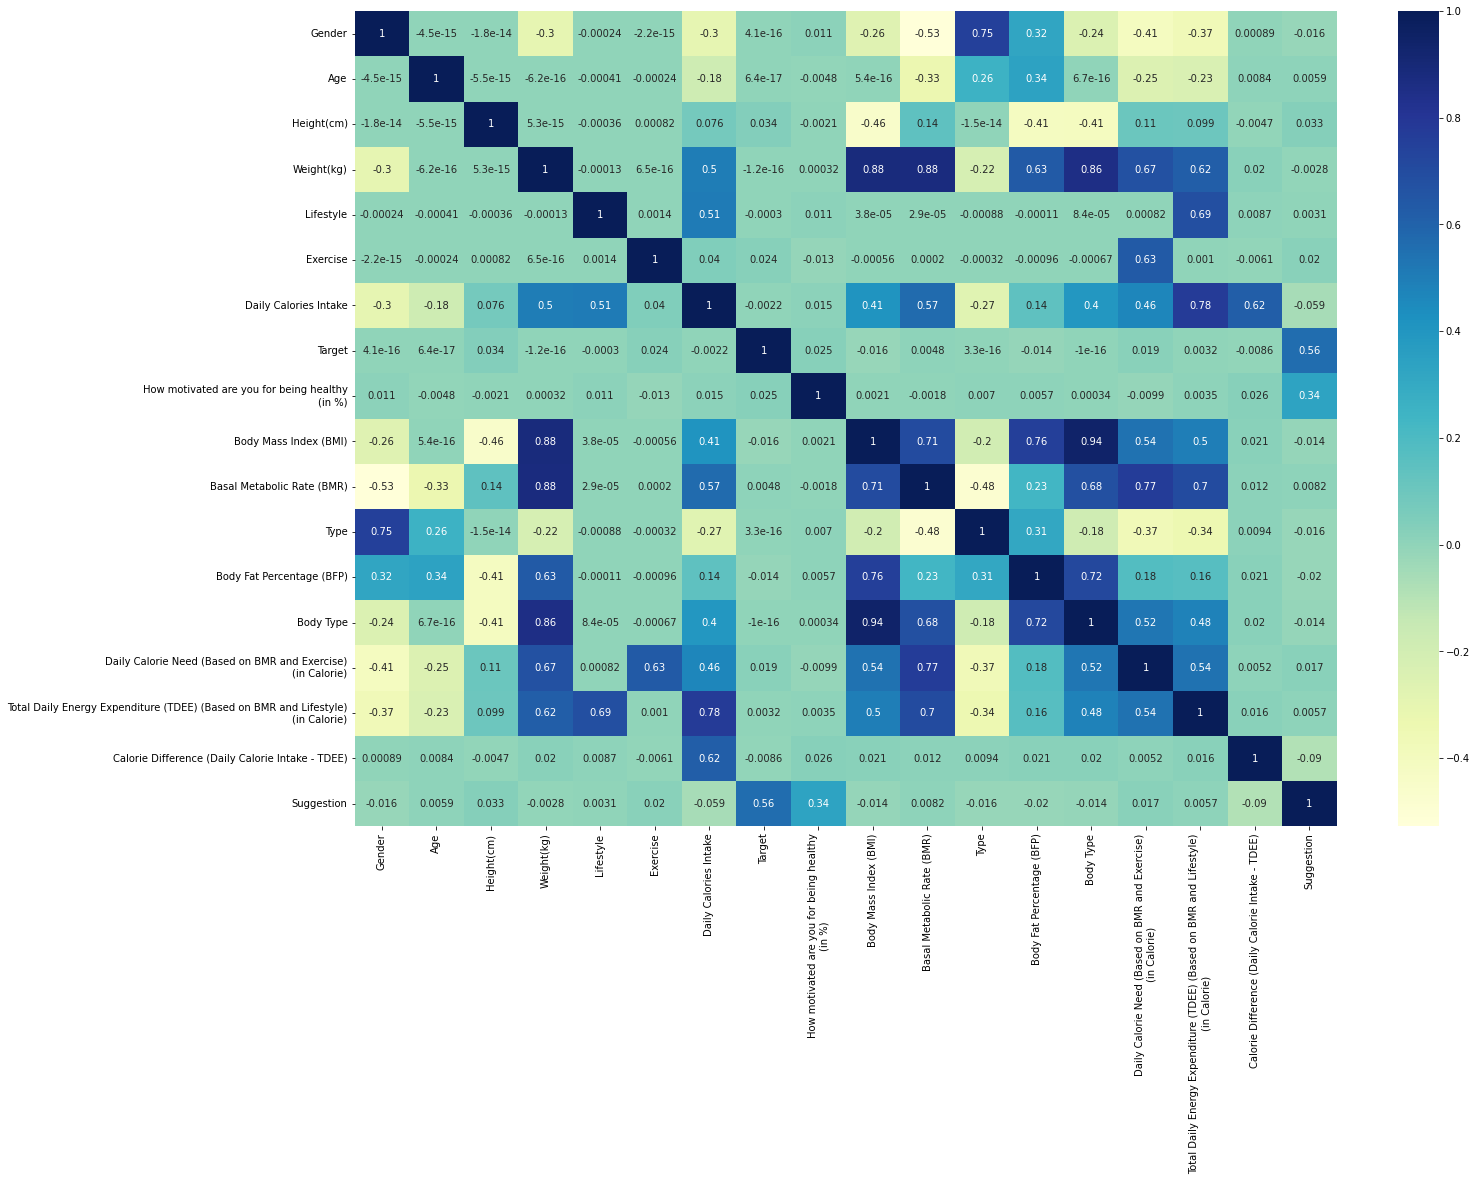

In [14]:
plt.figure(figsize=(22, 15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [15]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

print(to_drop)

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

['Body Type']


In [16]:
## checking correlation after normalizing the data
df_scaled = StandardScaler().fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE),Suggestion
0,-1.0,-1.704309,-1.46385,-1.243933,-1.224988,-1.360019,-0.948266,-1.224745,0.237504,-0.592030,-0.541999,-3.618136,-1.298428,-1.199687,-1.055461,-0.168609,-1.113972
1,-1.0,-1.704309,-1.46385,-1.006993,-1.224988,-0.473050,-1.385131,0.000000,0.043670,-0.342490,-0.321641,-3.618136,-1.017369,-0.530306,-0.926927,-1.307818,-0.439284
2,-1.0,-1.704309,-1.46385,-0.770054,-1.224988,0.413919,-1.138050,1.224745,-1.216250,-0.092950,-0.101283,-3.618136,-0.736309,0.179420,-0.798394,-1.023016,-0.439284
3,-1.0,-1.704309,-1.46385,-0.533114,1.224502,1.300887,-0.361060,-1.224745,0.431338,0.156589,0.119074,-3.618136,-0.455250,0.929492,1.043408,-1.545153,0.910093
4,-1.0,-1.704309,-1.46385,-0.296174,-1.224988,-1.360019,-1.239652,0.000000,-0.247081,0.406129,0.339432,-3.618136,-0.174191,-0.646370,-0.541326,-1.478699,-0.439284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,1.0,1.565182,1.46385,0.296174,1.224502,1.300887,1.246541,0.000000,1.109757,-0.404250,-0.455130,0.904534,0.766252,0.411337,0.550863,1.255402,-0.439284
10076,1.0,1.565182,1.46385,0.533114,1.224502,-1.360019,1.136394,1.224745,1.303591,-0.230196,-0.301873,0.904534,0.922045,-1.048948,0.682325,0.913640,2.259470
10077,1.0,1.565182,1.46385,0.770054,1.224502,-0.473050,-0.283890,-1.224745,-0.731665,-0.056142,-0.148616,0.904534,1.077837,-0.405851,0.813787,-1.250857,-1.113972
10078,1.0,1.565182,1.46385,1.006993,1.224502,0.413919,0.337951,0.000000,0.915923,0.117912,0.004641,0.904534,1.233630,0.265307,0.945249,-0.510371,0.235405


<AxesSubplot:>

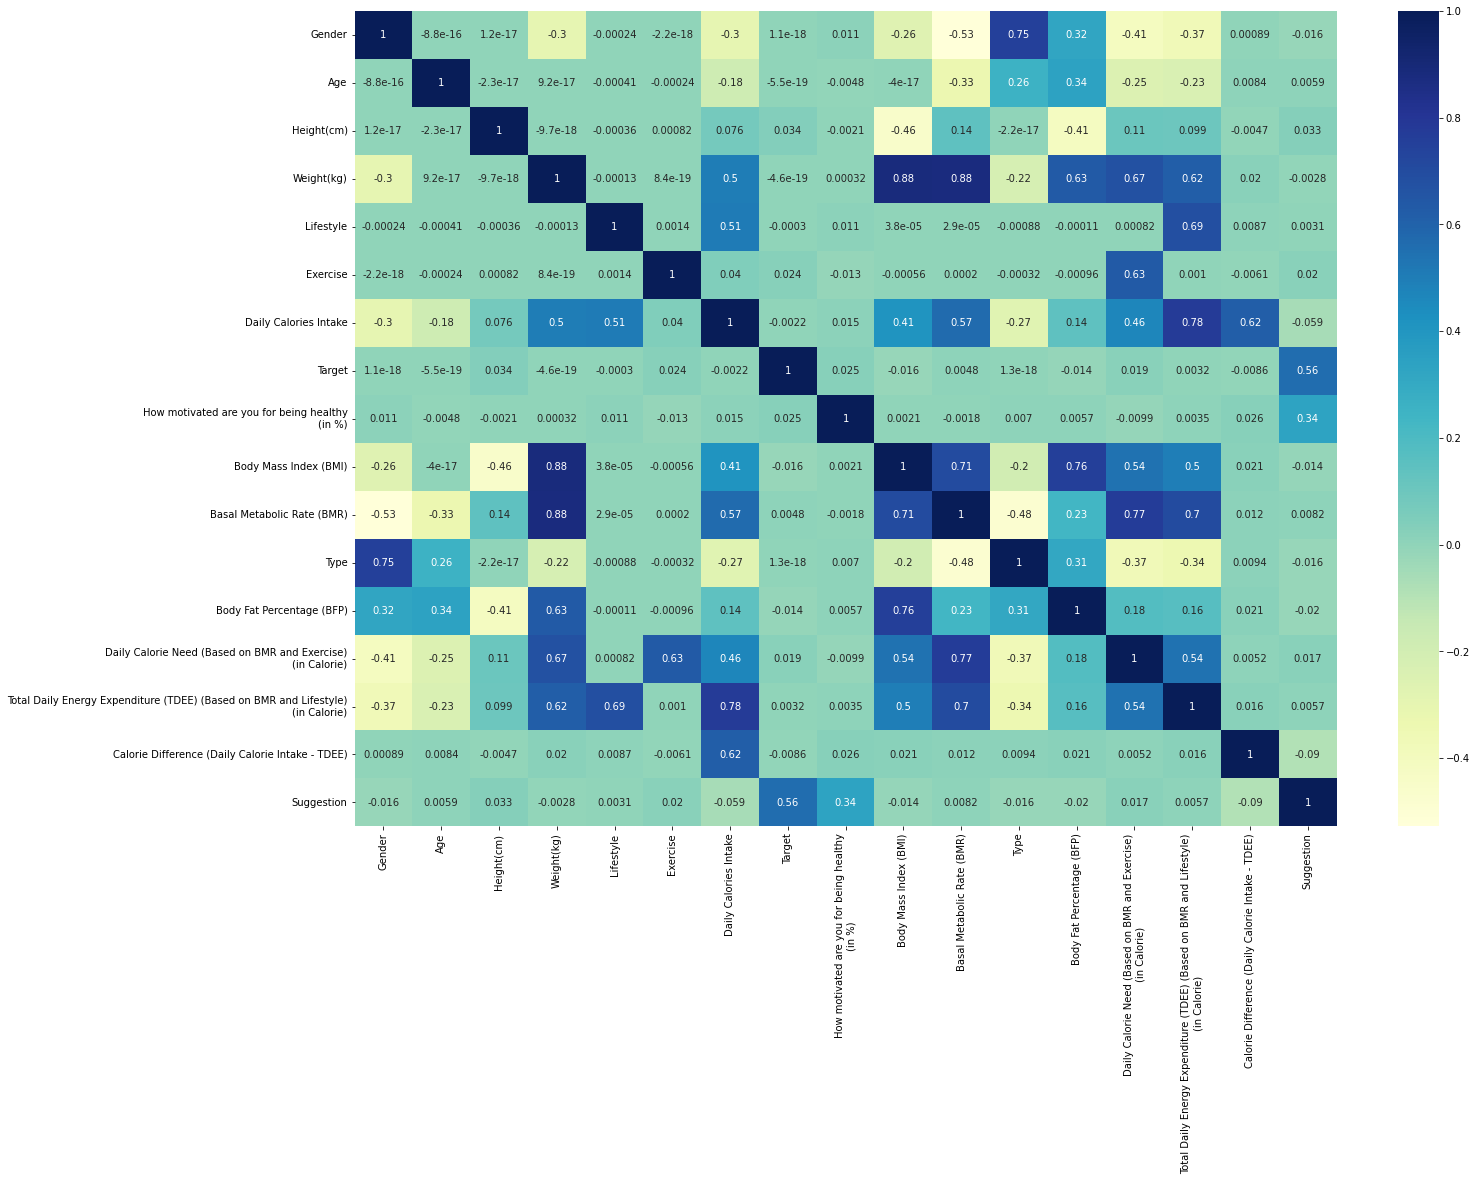

In [39]:
plt.figure(figsize=(22, 15))
sns.heatmap(df_scaled.corr(), cmap="YlGnBu", annot=True)

## Univariate Analysis
    - Performing Shaprio test before using any Non-parametric Test

In [40]:
def HypoTesting_Uni(pvalue, alpha = 0.05):
    if pvalue < alpha:
        return("Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)")
    else:
        return("Failed to Reject H0 (i.e., The variables follow a univariate normal distribution)*****")

In [41]:
for col in df_scaled.columns:
    test = shapiro(df_scaled[col])
    print("{} - {}".format(col, HypoTesting_Uni(test.pvalue)))

Gender - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Age - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Height(cm) - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Weight(kg) - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Lifestyle - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Exercise - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Daily Calories Intake - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Target - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
How motivated are you for being healthy
(in %) - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Body Mass Index (BMI) - Rejcting H0 (i.e., The variables don't follow a univariate normal distribution)
Basal Metabolic Rate (BMR) - R

## Comparing Two Samples
    - Performing Non-Parametric Test - Man Whitney

In [42]:
# conditioning to see if both sample come from same distribution
# H0 : mean1=mean2
# H1 : opposite H0
# If p-valu< α, then reject H0 (Mod 5 - Slide 9)

def HypoTesting(pvalue, alpha = 0.05):
    if pvalue < alpha:
        return("Rejcting H0 (i.e., They do not belong to same distribution)")
    else:
        return("Failed to Reject H0 (i.e., They belong to same distribution)*****")

In [43]:
for i in df.columns[:-1]:
    stats, pvalue = mannwhitneyu(df_scaled[str(i)].values, df_scaled['Suggestion'].values)
    print('{} vs Suggestion: Statistics={}, p-value={}'.format(i, stats, pvalue))
    print('{} vs Suggestion:'.format(i), HypoTesting(pvalue))
    print()

Gender vs Suggestion: Statistics=55535760.0, p-value=1.4284687575242532e-31
Gender vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Age vs Suggestion: Statistics=50053248.0, p-value=0.0681289782444675
Age vs Suggestion: Failed to Reject H0 (i.e., They belong to same distribution)*****

Height(cm) vs Suggestion: Statistics=55314000.0, p-value=4.525032465219178e-28
Height(cm) vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Weight(kg) vs Suggestion: Statistics=52887960.0, p-value=4.0130628436200426e-07
Weight(kg) vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Lifestyle vs Suggestion: Statistics=49091776.0, p-value=2.7916767131174795e-05
Lifestyle vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Exercise vs Suggestion: Statistics=49094528.0, p-value=3.043038832318388e-05
Exercise vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Daily Calories Intake vs S

<AxesSubplot:xlabel='Age', ylabel='Count'>

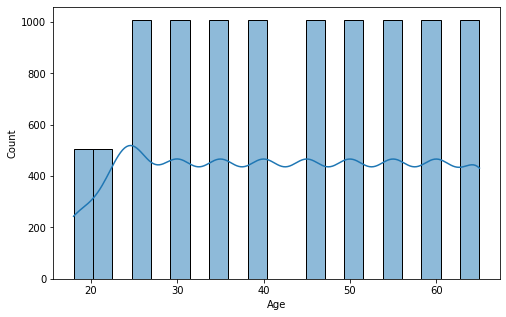

In [44]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], kde=True)

<AxesSubplot:xlabel='Suggestion', ylabel='Count'>

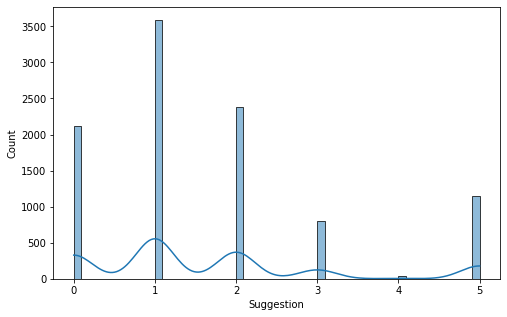

In [45]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Suggestion'], kde=True)

In [46]:
dist_age = distfit(distr=get_common_distributions())
dist_age.fit_transform(df_scaled[['Age', 'Suggestion']].values)
print(dist_age.summary)

[distfit] >fit..
[distfit] >transform..
[distfit] >[cauchy  ] [0.01 sec] [RSS: 11.0409] [loc=-0.214 scale=0.620]
[distfit] >[chi2    ] [0.16 sec] [RSS: 14.5557] [loc=-1.704 scale=1.027]
[distfit] >[expon   ] [0.0 sec] [RSS: 11.5406] [loc=-1.704 scale=1.704]
[distfit] >[exponpow] [0.29 sec] [RSS: 10.6254] [loc=-1.733 scale=2.729]
[distfit] >[gamma   ] [0.06 sec] [RSS: 10.5758] [loc=-2.193 scale=0.484]
[distfit] >[lognorm ] [0.14 sec] [RSS: 10.5989] [loc=-3.261 scale=3.112]
[distfit] >[norm    ] [0.0 sec] [RSS: 10.7722] [loc=-0.000 scale=1.000]
[distfit] >[powerlaw] [0.14 sec] [RSS: 11.0603] [loc=-1.704 scale=3.982]
[distfit] >[rayleigh] [0.01 sec] [RSS: 10.5837] [loc=-1.879 scale=1.505]
[distfit] >[uniform ] [0.0 sec] [RSS: 11.0569] [loc=-1.704 scale=3.964]
[distfit] >Compute confidence interval [parametric]
      distr      score  LLE       loc     scale                     arg
0     gamma  10.575817  NaN -2.192926  0.484065    (4.530230890611492,)
1  rayleigh  10.583659  NaN -1.878903

## Comparing Two Samples
    - Performing Non-Parametric Test - Wilcoxon Sign Rank Test

In [47]:
# find difference between Suggestion and rest of the columns

for i in df.columns[:-1]:
    diff = df_scaled[i].values - df['Suggestion'].values
    res_wil = wilcoxon(diff)
    print('{} vs Suggestion: Statistics={}, p-value={}'.format(i, res_wil.statistic, res_wil.pvalue))
    print('{} vs Suggestion:'.format(i), HypoTesting(res_wil.pvalue))
    print()

Gender vs Suggestion: Statistics=1484759.0, p-value=0.0
Gender vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Age vs Suggestion: Statistics=4518565.5, p-value=0.0
Age vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Height(cm) vs Suggestion: Statistics=3943978.0, p-value=0.0
Height(cm) vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Weight(kg) vs Suggestion: Statistics=4187350.5, p-value=0.0
Weight(kg) vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Lifestyle vs Suggestion: Statistics=4595142.0, p-value=0.0
Lifestyle vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Exercise vs Suggestion: Statistics=3229858.0, p-value=0.0
Exercise vs Suggestion: Rejcting H0 (i.e., They do not belong to same distribution)

Daily Calories Intake vs Suggestion: Statistics=4413551.0, p-value=0.0
Daily Calories Intake vs Suggestion: Rejcting H0 (i.e., They do not belong 

## Multivariate Analysis

In [48]:
def HypoTesting_Multi(pvalue, alpha = 0.05):
    if pvalue < alpha:
        return("Rejcting H0 (i.e., The variables don't follow a multivariate normal distribution)")
    else:
        return("Failed to Reject H0 (i.e., The variables follow a multivariate normal distribution)*****")

In [49]:
test_multi = multivariate_normality(df_scaled)
test_multi

HZResults(hz=3.084945844896956, pval=0.0, normal=False)

In [50]:
HypoTesting_Multi(test_multi.pval)

"Rejcting H0 (i.e., The variables don't follow a multivariate normal distribution)"

## Comparing More than two Samples
    - Performing Non-Parametric Test - KW Test

In [51]:
df_scaled.shape

(10080, 17)

In [52]:
# conditioning to see if n samples come from same distribution
# H0 : mean1=mean2=mean3......=meanN
# H1 : opposite H0
# If p-valu< α, then reject H0 

def HypoTesting(pvalue, alpha = 0.05):
    if pvalue < alpha:
        return("Rejecting H0 (i.e., They don't have the same means)")
    else:
        return("Failed to Reject H0 (i.e., They have the same means)*****")

In [53]:
stat, pvalue = kruskal(df_scaled.iloc[:, 0],
                      df_scaled.iloc[:, 1],
                      df_scaled.iloc[:, 2],
                      df_scaled.iloc[:, 3],
                      df_scaled.iloc[:, 4],
                      df_scaled.iloc[:, 5],
                      df_scaled.iloc[:, 6],
                      df_scaled.iloc[:, 7],
                      df_scaled.iloc[:, 8],
                      df_scaled.iloc[:, 9],
                      df_scaled.iloc[:, 10],
                      df_scaled.iloc[:, 11],
                      df_scaled.iloc[:, 12],
                      df_scaled.iloc[:, 13],
                      df_scaled.iloc[:, 14],
                      df_scaled.iloc[:, 15],
                      df_scaled.iloc[:, 16])

print(HypoTesting(pvalue))

Rejecting H0 (i.e., They don't have the same means)


In [18]:
df_new = pd.read_excel('Exercise.xlsx')
df_new.columns = list(df_new.iloc[0, :].values)
df_new.drop(index=0, inplace=True)
df_new.drop('Name', axis=1, inplace=True)
df_new.head()

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE),Suggestion
1,Male,18,152,50,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),2067.152431,Loose Weight,80,21.641274,1392.866,Boy,17.878324,Normal,1671.4392,2131.08498,-0.03,LOW CARB DIET (25:35:40)
2,Male,18,152,54,1. Sedentary or light activity (e.g. - Office ...,2. Lightly active (light exercise/sports 1-3 d...,1705.730935,Maintain Weight,78,23.372576,1447.866,Boy,20.49259,Normal,1990.81575,2215.23498,-0.23,BALANCE DIET (55:25:20)
3,Male,18,152,58,1. Sedentary or light activity (e.g. - Office ...,3. Moderately active (moderate exercise/sports...,1910.142686,Gain Muscle,65,25.103878,1502.866,Boy,23.106856,Overweight,2329.4423,2299.38498,-0.18,BALANCE DIET (55:25:20)
4,Male,18,152,62,3. Vigorously active (Agricultural worker (non...,4. Very active (hard exercise/sports 6-7 days ...,2552.952908,Loose Weight,82,26.83518,1557.866,Boy,25.721122,Overweight,2687.31885,3505.1985,-0.271667,KETOGENIC DIET (5:35:60)
5,Male,18,152,66,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),1826.086885,Maintain Weight,75,28.566482,1612.866,Boy,28.335388,Overweight,1935.4392,2467.68498,-0.26,BALANCE DIET (55:25:20)


In [19]:
df_new['Suggestion'].unique(), len(df_new['Suggestion'].unique())

(array(['LOW CARB DIET (25:35:40)', 'BALANCE DIET (55:25:20)',
        'KETOGENIC DIET (5:35:60)', 'HIGH CARB DIET(60:20:20)',
        'ZONE DIET (40:30:30)', 'DEPLETION DIET (DYNAMIC)'], dtype=object),
 6)

## Nemenyi's Test

In [36]:
nemenyi = posthoc_nemenyi(np.array([df_scaled['Age'].values, df_new['Suggestion'].values]).T)
nemenyi

,BALANCE DIET (55:25:20),DEPLETION DIET (DYNAMIC),HIGH CARB DIET(60:20:20),KETOGENIC DIET (5:35:60),LOW CARB DIET (25:35:40),ZONE DIET (40:30:30)
BALANCE DIET (55:25:20),1.000000,0.453439,0.700857,0.998839,0.841354,0.996381
DEPLETION DIET (DYNAMIC),0.453439,1.000000,0.292058,0.414480,0.337648,0.406377
HIGH CARB DIET(60:20:20),0.700857,0.292058,1.000000,0.979569,0.998008,0.921993
KETOGENIC DIET (5:35:60),0.998839,0.414480,0.979569,1.000000,0.998476,1.000000
LOW CARB DIET (25:35:40),0.841354,0.337648,0.998008,0.998476,1.000000,0.987238
ZONE DIET (40:30:30),0.996381,0.406377,0.921993,1.000000,0.987238,1.000000


In [57]:
id_low = df_new[df_new['Suggestion'] == 'LOW CARB DIET (25:35:40)'].index
id_low

Int64Index([    1,     7,    13,    16,    22,    31,    37,    40,    46,
               52,
            ...
            10015, 10021, 10022, 10030, 10045, 10052, 10060, 10066, 10075,
            10078],
           dtype='int64', length=2123)

In [58]:
id_balanced = df_new[df_new['Suggestion'] == 'BALANCE DIET (55:25:20)'].index
id_balanced

Int64Index([    2,     3,     5,     8,    11,    14,    17,    20,    23,
               26,
            ...
            10057, 10058, 10061, 10064, 10067, 10069, 10070, 10072, 10073,
            10076],
           dtype='int64', length=3589)

No difference in the means


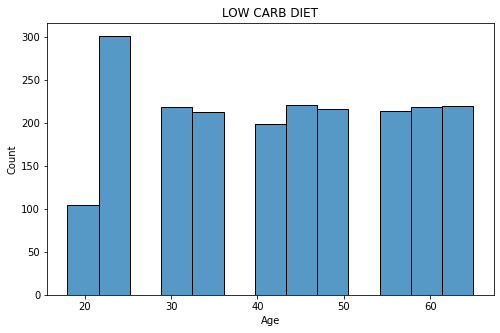

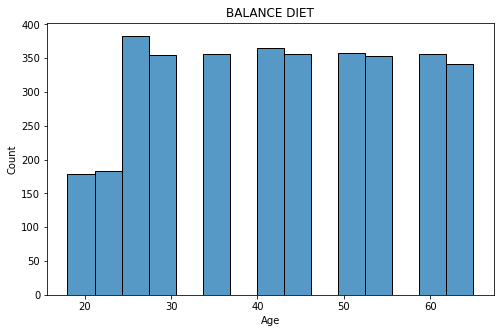

In [59]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_low, 1])

print("No difference in the means")

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("LOW CARB DIET")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_balanced, 1])

plt.xlabel("Age")
plt.ylabel("Count")
plt.title("BALANCE DIET")
plt.show()

In [35]:
nemenyi = posthoc_nemenyi(np.array([df_scaled['Daily Calories Intake'].values, df_new['Suggestion'].values]).T)
nemenyi

,BALANCE DIET (55:25:20),DEPLETION DIET (DYNAMIC),HIGH CARB DIET(60:20:20),KETOGENIC DIET (5:35:60),LOW CARB DIET (25:35:40),ZONE DIET (40:30:30)
BALANCE DIET (55:25:20),1.000000e+00,6.740926e-11,9.275220e-01,5.000191e-46,3.700934e-75,3.987428e-78
DEPLETION DIET (DYNAMIC),6.740926e-11,1.000000e+00,2.236086e-11,4.704168e-03,9.823249e-04,7.955119e-04
HIGH CARB DIET(60:20:20),9.275220e-01,2.236086e-11,1.000000e+00,1.278483e-37,3.963711e-48,1.566790e-48
KETOGENIC DIET (5:35:60),5.000191e-46,4.704168e-03,1.278483e-37,1.000000e+00,7.810958e-01,6.589030e-01
LOW CARB DIET (25:35:40),3.700934e-75,9.823249e-04,3.963711e-48,7.810958e-01,1.000000e+00,9.998936e-01
ZONE DIET (40:30:30),3.987428e-78,7.955119e-04,1.566790e-48,6.589030e-01,9.998936e-01,1.000000e+00


In [61]:
id_high = df_new[df_new['Suggestion'] == 'HIGH CARB DIET(60:20:20)'].index
id_high

Int64Index([    6,    18,    24,    30,    36,    39,    45,    48,    51,
               54,
            ...
             9999, 10008, 10011, 10026, 10029, 10053, 10056, 10071, 10074,
            10077],
           dtype='int64', length=1151)

In [62]:
id_keto = df_new[df_new['Suggestion'] == 'KETOGENIC DIET (5:35:60)'].index
id_keto

Int64Index([    4,    10,    19,    25,    28,    34,    49,    55,    82,
               88,
            ...
             9982, 10003, 10006, 10018, 10024, 10033, 10036, 10048, 10051,
            10063],
           dtype='int64', length=799)

No difference in the means


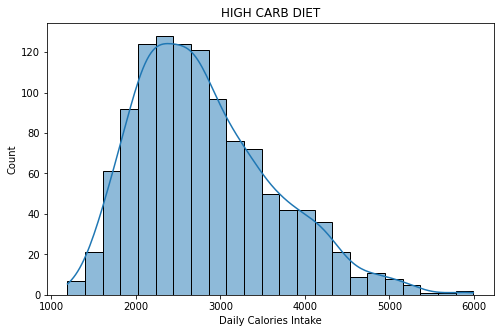

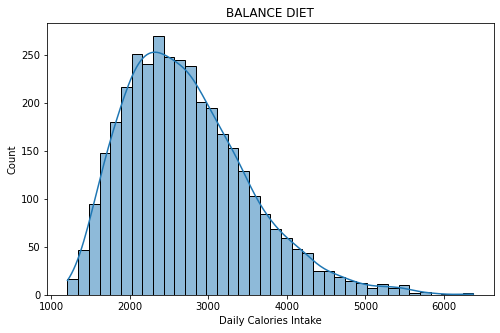

In [63]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_high, 6], kde=True)

print("No difference in the means")

plt.xlabel("Daily Calories Intake")
plt.ylabel("Count")
plt.title("HIGH CARB DIET")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_balanced, 6], kde=True)

plt.xlabel("Daily Calories Intake")
plt.ylabel("Count")
plt.title("BALANCE DIET")
plt.show()

There is difference in the means


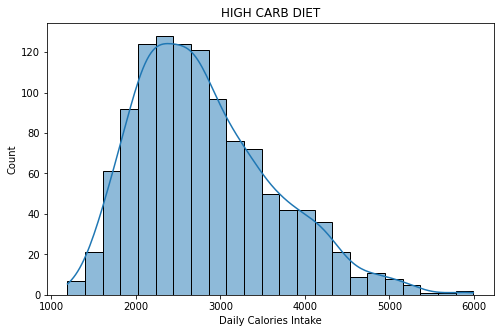

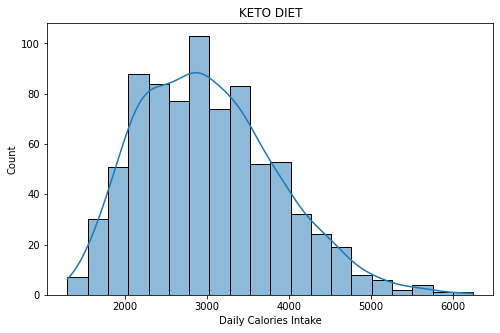

In [64]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_high, 6], kde=True)

print("There is difference in the means")

plt.xlabel("Daily Calories Intake")
plt.ylabel("Count")
plt.title("HIGH CARB DIET")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_keto, 6], kde=True)

plt.xlabel("Daily Calories Intake")
plt.ylabel("Count")
plt.title("KETO DIET")
plt.show()

In [37]:
nemenyi = posthoc_nemenyi(np.array([df_scaled['Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie)'].values, df_new['Suggestion'].values]).T)
nemenyi

,BALANCE DIET (55:25:20),DEPLETION DIET (DYNAMIC),HIGH CARB DIET(60:20:20),KETOGENIC DIET (5:35:60),LOW CARB DIET (25:35:40),ZONE DIET (40:30:30)
BALANCE DIET (55:25:20),1.000000e+00,0.007668,1.365045e-03,3.275007e-53,1.486854e-48,1.169404e-28
DEPLETION DIET (DYNAMIC),7.668021e-03,1.000000,9.234170e-02,9.995854e-01,7.837416e-01,4.536798e-01
HIGH CARB DIET(60:20:20),1.365045e-03,0.092342,1.000000e+00,2.448274e-21,2.469195e-10,9.697109e-04
KETOGENIC DIET (5:35:60),3.275007e-53,0.999585,2.448274e-21,1.000000e+00,1.521746e-04,2.792525e-11
LOW CARB DIET (25:35:40),1.486854e-48,0.783742,2.469195e-10,1.521746e-04,1.000000e+00,2.912763e-02
ZONE DIET (40:30:30),1.169404e-28,0.453680,9.697109e-04,2.792525e-11,2.912763e-02,1.000000e+00


There is difference in the means


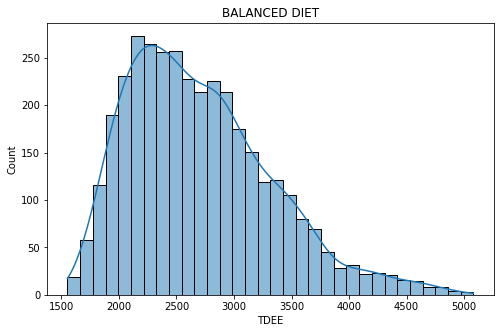

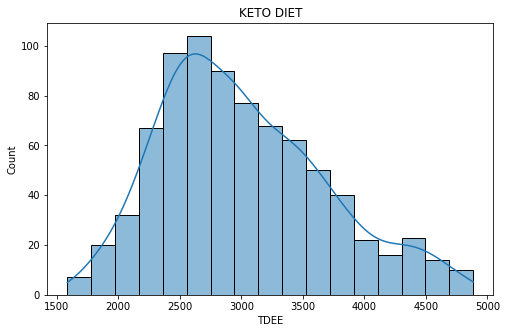

In [66]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_balanced, 15], kde=True)

print("There is difference in the means")

plt.xlabel("TDEE")
plt.ylabel("Count")
plt.title("BALANCED DIET")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_keto, 15], kde=True)

plt.xlabel("TDEE")
plt.ylabel("Count")
plt.title("KETO DIET")
plt.show()

In [67]:
id_dep = df_new[df_new['Suggestion'] == 'DEPLETION DIET (DYNAMIC)'].index
id_dep

Int64Index([  56,   92,   97,   98,  106,  107,  205,  344,  427,  515,  629,
             949, 1451, 1817, 1954, 2672, 3260, 3556, 3802, 4070, 4139, 4642,
            4772, 5515, 6061, 6229, 6493, 6577, 6860, 7531, 8509, 8860, 9506],
           dtype='int64')

In [68]:
id_zone = df_new[df_new['Suggestion'] == 'ZONE DIET (40:30:30)'].index
id_zone

Int64Index([    9,    12,    15,    21,    27,    33,    35,    42,    50,
               57,
            ...
            10041, 10044, 10047, 10050, 10059, 10062, 10065, 10068, 10079,
            10080],
           dtype='int64', length=2385)

No difference in the means


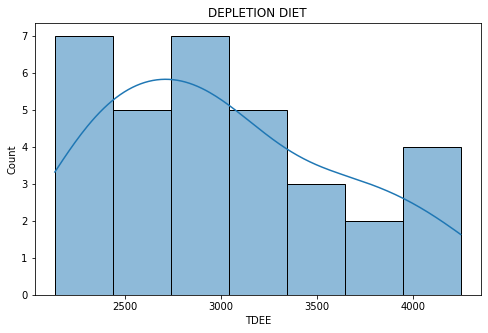

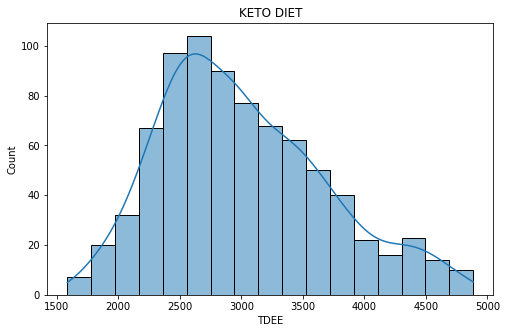

In [69]:
plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_dep, 15], kde=True)

print("No difference in the means")

plt.xlabel("TDEE")
plt.ylabel("Count")
plt.title("DEPLETION DIET")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df_new.iloc[id_keto, 15], kde=True)

plt.xlabel("TDEE")
plt.ylabel("Count")
plt.title("KETO DIET")
plt.show()

## Categorical Analysis
    - Performing Chi-square test of independence

In [70]:
df_new.head(2)

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE),Suggestion
1,Male,18,152,50,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),2067.152431,Loose Weight,80,21.641274,1392.866,Boy,17.878324,Normal,1671.4392,2131.08498,-0.03,LOW CARB DIET (25:35:40)
2,Male,18,152,54,1. Sedentary or light activity (e.g. - Office ...,2. Lightly active (light exercise/sports 1-3 d...,1705.730935,Maintain Weight,78,23.372576,1447.866,Boy,20.49259,Normal,1990.81575,2215.23498,-0.23,BALANCE DIET (55:25:20)


In [71]:
df_new.columns

Index(['Gender', 'Age', 'Height(cm)', 'Weight(kg)', 'Lifestyle', 'Exercise',
       'Daily Calories Intake', 'Target',
       'How motivated are you for being healthy\n(in %)',
       'Body Mass Index (BMI)', 'Basal Metabolic Rate (BMR)', 'Type',
       'Body Fat Percentage (BFP)', 'Body Type',
       'Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie)',
       'Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie)',
       'Calorie Difference (Daily Calorie Intake - TDEE)', 'Suggestion'],
      dtype='object')

In [72]:
# categorical columns = Lifestyle, Suggestion, Target, Body Type

chisq_test_1 = pd.crosstab(df_new['Exercise'], df_new['Suggestion'])
chisq_test_1

Suggestion,BALANCE DIET (55:25:20),DEPLETION DIET (DYNAMIC),HIGH CARB DIET(60:20:20),KETOGENIC DIET (5:35:60),LOW CARB DIET (25:35:40),ZONE DIET (40:30:30)
Exercise,,,,,,
1. Sedentary (little or no exercise),945,8,235,228,548,500
2. Lightly active (light exercise/sports 1-3 days/ week),904,4,305,149,459,643
3. Moderately active (moderate exercise/sports 3-5days/week),764,12,308,208,552,620
4. Very active (hard exercise/sports 6-7 days a week),976,9,303,214,564,622


In [73]:
stat, p, dof, expected = chi2_contingency(chisq_test_1)
print(stat, p)

85.80798443723344 5.963255839629829e-12


In [74]:
if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent.")
else:
    print("Failed to Reject H0")

Reject - H0: (null hypothesis) The two variables are independent.


In [75]:
chisq_test_2 = pd.crosstab(df_new['Lifestyle'], df_new['Suggestion'])
stat, p, dof, expected = chi2_contingency(chisq_test_2)
print(stat, p)

if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent.")
else:
    print("Failed to Reject H0")

11.593036223543177 0.3132156769579751
Failed to Reject H0


In [76]:
chisq_test_2

Suggestion,BALANCE DIET (55:25:20),DEPLETION DIET (DYNAMIC),HIGH CARB DIET(60:20:20),KETOGENIC DIET (5:35:60),LOW CARB DIET (25:35:40),ZONE DIET (40:30:30)
Lifestyle,,,,,,
1. Sedentary or light activity (e.g. - Office worker getting little or no exercise),1191,18,361,260,711,818
2. Active or moderately active (Construction worker or person running one hour daily),1197,6,404,277,695,781
3. Vigorously active (Agricultural worker (non mechanized) or person swimming two hours daily),1201,9,386,262,717,786


In [77]:
chisq_test_3 = pd.crosstab(df_new['Lifestyle'], df_new['Exercise'])
stat, p, dof, expected = chi2_contingency(chisq_test_3)
print(stat, p)

if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent.")
else:
    print("Failed to Reject H0")

0.029233343365515432 0.9999994852041799
Failed to Reject H0


In [78]:
chisq_test_3

Exercise,1. Sedentary (little or no exercise),2. Lightly active (light exercise/sports 1-3 days/ week),3. Moderately active (moderate exercise/sports 3-5days/week),4. Very active (hard exercise/sports 6-7 days a week)
Lifestyle,,,,
1. Sedentary or light activity (e.g. - Office worker getting little or no exercise),822,822,822,893
2. Active or moderately active (Construction worker or person running one hour daily),822,822,820,896
3. Vigorously active (Agricultural worker (non mechanized) or person swimming two hours daily),820,820,822,899


In [79]:
chisq_test_4 = pd.crosstab(df_new['Target'], df_new['Suggestion'])
stat, p, dof, expected = chi2_contingency(chisq_test_4)
print(stat, p)

if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent.")
else:
    print("Failed to Reject H0")

12540.08841237544 0.0
Reject - H0: (null hypothesis) The two variables are independent.


In [80]:
chisq_test_4

Suggestion,BALANCE DIET (55:25:20),DEPLETION DIET (DYNAMIC),HIGH CARB DIET(60:20:20),KETOGENIC DIET (5:35:60),LOW CARB DIET (25:35:40),ZONE DIET (40:30:30)
Target,,,,,,
Gain Muscle,174,0,1151,0,0,2035
Loose Weight,720,17,0,799,1824,0
Maintain Weight,2695,16,0,0,299,350


In [81]:
chisq_test_5 = pd.crosstab(df_new['Target'], df_new['Lifestyle'])
stat, p, dof, expected = chi2_contingency(chisq_test_5)
print(stat, p)

if p < 0.05:
    print("Reject - H0: (null hypothesis) The two variables are independent.")
else:
    print("Failed to Reject H0")

0.0011904762959251253 0.9999998229160573
Failed to Reject H0


In [82]:
chisq_test_5

Lifestyle,1. Sedentary or light activity (e.g. - Office worker getting little or no exercise),2. Active or moderately active (Construction worker or person running one hour daily),3. Vigorously active (Agricultural worker (non mechanized) or person swimming two hours daily)
Target,,,
Gain Muscle,1120,1120,1120
Loose Weight,1119,1120,1121
Maintain Weight,1120,1120,1120


## Selecting 'n' best features using SelectKBest()
    - Using F values of ANOVA (F-Test)

In [96]:
data = pd.read_excel('Exercise.xlsx')
data.columns = list(data.iloc[0, :].values)
data.drop(index=0, inplace=True)
data.drop('Name', axis=1, inplace=True)
data.head()

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE),Suggestion
1,Male,18,152,50,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),2067.152431,Loose Weight,80,21.641274,1392.866,Boy,17.878324,Normal,1671.4392,2131.08498,-0.03,LOW CARB DIET (25:35:40)
2,Male,18,152,54,1. Sedentary or light activity (e.g. - Office ...,2. Lightly active (light exercise/sports 1-3 d...,1705.730935,Maintain Weight,78,23.372576,1447.866,Boy,20.49259,Normal,1990.81575,2215.23498,-0.23,BALANCE DIET (55:25:20)
3,Male,18,152,58,1. Sedentary or light activity (e.g. - Office ...,3. Moderately active (moderate exercise/sports...,1910.142686,Gain Muscle,65,25.103878,1502.866,Boy,23.106856,Overweight,2329.4423,2299.38498,-0.18,BALANCE DIET (55:25:20)
4,Male,18,152,62,3. Vigorously active (Agricultural worker (non...,4. Very active (hard exercise/sports 6-7 days ...,2552.952908,Loose Weight,82,26.83518,1557.866,Boy,25.721122,Overweight,2687.31885,3505.1985,-0.271667,KETOGENIC DIET (5:35:60)
5,Male,18,152,66,1. Sedentary or light activity (e.g. - Office ...,1. Sedentary (little or no exercise),1826.086885,Maintain Weight,75,28.566482,1612.866,Boy,28.335388,Overweight,1935.4392,2467.68498,-0.26,BALANCE DIET (55:25:20)


In [97]:
# Mapping String to numeric values.
data['Gender']=data['Gender'].map({"Male":0,"Female":1})
data['Body Type']=data['Body Type'].map({"Underweight":0,"Normal":1,"Overweight":2,"Obese":3})
data['Type']=data['Type'].map({"Boy":0,"Girl":1,"Adult Male":2,"Adult Female":3})
data['Suggestion']=data['Suggestion'].map({"LOW CARB DIET (25:35:40)":0,"BALANCE DIET (55:25:20)":1,"ZONE DIET (40:30:30)":2,"KETOGENIC DIET (5:35:60)":3,"DEPLETION DIET (DYNAMIC)":4,"HIGH CARB DIET(60:20:20)":5})
data['Target']=data['Target'].map({"Loose Weight":0,"Maintain Weight":1,"Gain Muscle":2})
data['Lifestyle']=data['Lifestyle'].map({"1. Sedentary or light activity (e.g. - Office worker getting little or no exercise)":0,"2. Active or moderately active (Construction worker or person running one hour daily)":1,"3. Vigorously active (Agricultural worker (non mechanized) or person swimming two hours daily)":2})
data['Exercise']=data['Exercise'].map({"1. Sedentary (little or no exercise)":0,"2. Lightly active (light exercise/sports 1-3 days/ week)":1,"3. Moderately active (moderate exercise/sports 3-5days/week)":2,"4. Very active (hard exercise/sports 6-7 days a week)":3})

In [98]:
data = data.apply(pd.to_numeric)

In [99]:
X = data.iloc[:, :-1]
X.shape

(10080, 17)

In [100]:
Y = data.iloc[:, -1]
Y.shape

(10080,)

In [101]:
sc_scaler = StandardScaler()
X = sc_scaler.fit_transform(X)
X.shape

(10080, 17)

In [105]:
X = pd.DataFrame(X, columns=list(data.columns)[:-1])
X

,Gender,Age,Height(cm),Weight(kg),Lifestyle,Exercise,Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Type,Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE)
0,-1.0,-1.704309,-1.46385,-1.243933,-1.224988,-1.360019,-0.948266,-1.224745,0.237504,-0.592030,-0.541999,-3.618136,-1.298428,-0.607181,-1.199687,-1.055461,-0.168609
1,-1.0,-1.704309,-1.46385,-1.006993,-1.224988,-0.473050,-1.385131,0.000000,0.043670,-0.342490,-0.321641,-3.618136,-1.017369,-0.607181,-0.530306,-0.926927,-1.307818
2,-1.0,-1.704309,-1.46385,-0.770054,-1.224988,0.413919,-1.138050,1.224745,-1.216250,-0.092950,-0.101283,-3.618136,-0.736309,0.346150,0.179420,-0.798394,-1.023016
3,-1.0,-1.704309,-1.46385,-0.533114,1.224502,1.300887,-0.361060,-1.224745,0.431338,0.156589,0.119074,-3.618136,-0.455250,0.346150,0.929492,1.043408,-1.545153
4,-1.0,-1.704309,-1.46385,-0.296174,-1.224988,-1.360019,-1.239652,0.000000,-0.247081,0.406129,0.339432,-3.618136,-0.174191,0.346150,-0.646370,-0.541326,-1.478699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,1.0,1.565182,1.46385,0.296174,1.224502,1.300887,1.246541,0.000000,1.109757,-0.404250,-0.455130,0.904534,0.766252,-0.607181,0.411337,0.550863,1.255402
10076,1.0,1.565182,1.46385,0.533114,1.224502,-1.360019,1.136394,1.224745,1.303591,-0.230196,-0.301873,0.904534,0.922045,-0.607181,-1.048948,0.682325,0.913640
10077,1.0,1.565182,1.46385,0.770054,1.224502,-0.473050,-0.283890,-1.224745,-0.731665,-0.056142,-0.148616,0.904534,1.077837,0.346150,-0.405851,0.813787,-1.250857
10078,1.0,1.565182,1.46385,1.006993,1.224502,0.413919,0.337951,0.000000,0.915923,0.117912,0.004641,0.904534,1.233630,0.346150,0.265307,0.945249,-0.510371


In [90]:
for i in range(10, 16):
    select_clf = SelectKBest(score_func=f_classif, k=i)
    select_clf.fit(X, Y)
    new_X = X.iloc[:,select_clf.get_support()]
    
    x_train, x_test, y_train, y_test = train_test_split(new_X, data.iloc[:, -1], test_size=0.2, random_state=1)
    
    log_reg = sm.MNLogit(y_train.values.ravel(), x_train).fit()
    
    clf = LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1).fit(x_train, y_train)
    
    print("Features = {}, AIC = {}, Train Acc = {}, Test Acc = {}".format(i, log_reg.aic, accuracy_score(y_train, clf.predict(x_train)), accuracy_score(y_test, clf.predict(x_test))))

Optimization terminated successfully.
         Current function value: 0.993554
         Iterations 8
Features = 10, AIC = 16124.0336195591, Train Acc = 0.8551587301587301, Test Acc = 0.8571428571428571
Optimization terminated successfully.
         Current function value: 0.978977
         Iterations 8
Features = 11, AIC = 15898.947466843001, Train Acc = 0.8611111111111112, Test Acc = 0.8650793650793651
Optimization terminated successfully.
         Current function value: 0.974188
         Iterations 8
Features = 12, AIC = 15831.698119278528, Train Acc = 0.8587549603174603, Test Acc = 0.8621031746031746
Optimization terminated successfully.
         Current function value: 0.972083
         Iterations 8
Features = 13, AIC = 15807.746588902739, Train Acc = 0.8586309523809523, Test Acc = 0.8635912698412699
Optimization terminated successfully.
         Current function value: 0.971832
         Iterations 8
Features = 14, AIC = 15813.700787090916, Train Acc = 0.8588789682539683, Test Ac

In [115]:
x_train, x_test, y_train, y_test = train_test_split(X, data.iloc[:, -1], test_size=0.2, random_state=1)

In [116]:
select_clf = SelectKBest(score_func=f_classif, k=13)
select_clf.fit(x_train, y_train)

SelectKBest(k=13)

In [117]:
kept_features = pd.DataFrame({'Columns': X.columns,
                              'Kept': select_clf.get_support()})
kept_features

,Columns,Kept
0,Gender,True
1,Height(cm),True
2,Weight(kg),True
3,Daily Calories Intake,True
4,Target,True
5,How motivated are you for being healthy\n(in %),True
6,Body Mass Index (BMI),True
7,Basal Metabolic Rate (BMR),True
8,Body Fat Percentage (BFP),True
9,Body Type,True


In [118]:
X = X.iloc[:, select_clf.get_support()]
X

,Gender,Height(cm),Weight(kg),Daily Calories Intake,Target,How motivated are you for being healthy\n(in %),Body Mass Index (BMI),Basal Metabolic Rate (BMR),Body Fat Percentage (BFP),Body Type,Daily Calorie Need (Based on BMR and Exercise)\n(in Calorie),Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)\n(in Calorie),Calorie Difference (Daily Calorie Intake - TDEE)
0,-1.0,-1.46385,-1.243933,-0.948266,-1.224745,0.237504,-0.592030,-0.541999,-1.298428,-0.607181,-1.199687,-1.055461,-0.168609
1,-1.0,-1.46385,-1.006993,-1.385131,0.000000,0.043670,-0.342490,-0.321641,-1.017369,-0.607181,-0.530306,-0.926927,-1.307818
2,-1.0,-1.46385,-0.770054,-1.138050,1.224745,-1.216250,-0.092950,-0.101283,-0.736309,0.346150,0.179420,-0.798394,-1.023016
3,-1.0,-1.46385,-0.533114,-0.361060,-1.224745,0.431338,0.156589,0.119074,-0.455250,0.346150,0.929492,1.043408,-1.545153
4,-1.0,-1.46385,-0.296174,-1.239652,0.000000,-0.247081,0.406129,0.339432,-0.174191,0.346150,-0.646370,-0.541326,-1.478699
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,1.0,1.46385,0.296174,1.246541,0.000000,1.109757,-0.404250,-0.455130,0.766252,-0.607181,0.411337,0.550863,1.255402
10076,1.0,1.46385,0.533114,1.136394,1.224745,1.303591,-0.230196,-0.301873,0.922045,-0.607181,-1.048948,0.682325,0.913640
10077,1.0,1.46385,0.770054,-0.283890,-1.224745,-0.731665,-0.056142,-0.148616,1.077837,0.346150,-0.405851,0.813787,-1.250857
10078,1.0,1.46385,1.006993,0.337951,0.000000,0.915923,0.117912,0.004641,1.233630,0.346150,0.265307,0.945249,-0.510371


In [111]:
x_train, x_test, y_train, y_test = train_test_split(X, data.iloc[:, -1], test_size=0.2, random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8064, 13), (2016, 13), (8064,), (2016,))

In [112]:
log_reg_kbest = sm.MNLogit(y_train.values.ravel(), x_train).fit()
log_reg_kbest.aic

Optimization terminated successfully.
         Current function value: 0.972083
         Iterations 8


15807.746588902739

In [120]:
log_reg_kbest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                 8064
Model:                        MNLogit   Df Residuals:                     7999
Method:                           MLE   Df Model:                           60
Date:                Sun, 11 Dec 2022   Pseudo R-squ.:                  0.3541
Time:                        00:33:19   Log-Likelihood:                -7838.9
converged:                       True   LL-Null:                       -12136.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================================================================================
                                                                            y=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Gender                                                                              0.3895      0.104      3.738      0.000       0.185       0.594
Height(cm)                                                                          1.6991      0.215      7.903      0.000       1.278       2.120
Weight(kg)                                                                         -3.8164      0.519     -7.347      0.000      -4.835      -2.798
Daily Calories Intake                                                              -4.6112      0.337    -13.664      0.000      -5.273      -3.950
Target                                                                              2.1008      0.069     30.329      0.000       1.965       2.237
How motivated are you for being healthy
(in %)                                      0.2096      0.048      4.332      0.000       0.115       0.304
Body Mass Index (BMI)                                                               4.4916      0.515      8.730      0.000       3.483       5.500
Basal Metabolic Rate (BMR)                                                          0.1193      0.275      0.434      0.665      -0.420       0.659
Body Fat Percentage (BFP)                                                          -0.2244      0.250     -0.896      0.370      -0.715       0.267
Body Type                                                                          -2.1932      0.171    -12.813      0.000      -2.529      -1.858
Daily Calorie Need (Based on BMR and Exercise)
(in Calorie)                         0.0409      0.081      0.504      0.614      -0.118       0.200
Total Daily Energy Expenditure (TDEE) (Based on BMR and Lifestyle)
(in Calorie)     3.2579      0.248     13.139      0.000       2.772       3.744
Calorie Difference (Daily Calorie Intake - TDEE)                                    1.7420      0.195      8.923      0.000       1.359       2.125
---------------------------------------------------------------------------------------------------------------------------------------------------
                                                                            y=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
Gender                                                                              0.0007      0.113      0.006      0.995      -0.220       0.222
Height(cm)                                                                          0.3703      0.250      1.482      0.138      -0.119       0.860
Weight(kg)                                                                         -0.7957      0.549     -1.449      0.147      -1.8

In [121]:
log_reg_kbest.bic

16262.432313272964

## Resampling Methods
    - Using Cross validation

In [113]:
from sklearn.model_selection import cross_validate

lg_resultant = cross_validate(LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1), 
                              x_train, 
                              y_train, 
                              cv=5,
                              return_train_score=True)

print("Mean Training Score = ", lg_resultant['train_score'].mean()*100)
print("Mean Testing Score = ", lg_resultant['test_score'].mean()*100)

Mean Training Score =  85.8352002212684
Mean Testing Score =  85.40432958637867


    - Using Bootstrap

In [119]:
train_score = []
test_score = []
n_times = 10

## Performing bootstrapping
for i in range(n_times):
    
    x_train, x_test, y_train, y_test = train_test_split(X, data.iloc[:, -1], test_size=0.2, random_state=42+i)
    
    #choose from different tunable hyper parameters
    clf = LogisticRegression(C=10, multi_class='multinomial', n_jobs=-1).fit(x_train, y_train)
    y_pred = clf.predict(x_test)
 
    #Measuring accuracy on Testing Data
    Accuracy = accuracy_score(y_test, y_pred)
    
    # Storing accuracy values
    test_score.append(Accuracy)
    train_score.append(accuracy_score(y_train, clf.predict(x_train)))
    
################################################
# Result of all bootstrapping trials
print("Mean Training Score = ", np.mean(train_score)*100)
print("Mean Testing Score = ", np.mean(test_score)*100)

Mean Training Score =  85.84821428571429
Mean Testing Score =  85.9672619047619
